# Jupyter Notebook Template

In [1]:
import os
import re
import cv2
import sys
import random
import pandas as pd
import numpy as np
from typing import List
from PIL import Image
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
sys.setrecursionlimit(10000)

In [4]:
"""utils for working with images for the DISC Xray project
"""

def get_tag(image) -> str:
    """return substring of image path string that represents anomaly positions.

    :image:pd.series: image path.
    :rtype:str:       substring from image path specifiy anomaly.
    """
    pattern = re.compile("[pP]\d{2}")  # /1/ pattern matches existing image name convention
    return [split
            for split in image.split("_")
            if (pattern.match(split))] # /2/ different naming convention will require different tagging approach


def store_imgs(images: List[np.ndarray], directory: str, tag: str=None) -> None:
    """save numpy images as pngs locally.

    :images:List[np.ndarray]: numpy images.
    """
    for i in range(len(images)):
        for j in range(len(images[i])):
            name  = directory + tag + "_" + str(i) + "_" + str(j) + ".png"
            image = Image.fromarray(images[i][j])
            image.save(name)


def get_imgs(path: str) -> pd.DataFrame:
    """return pandas dataframe with paths of pngs.

    :path:str:           image path.
    :rtype:pd.DataFrame: png paths.
    """
    return pd.DataFrame([img for img in os.listdir(path) if img[-3:]=='png'])


def get_imgtypes(images: pd.DataFrame) -> List[str]:
    """get image types for use with method subset_imgs.

    [NOTE] requires indexing row with 0 because iterrows returned Series object.

    :images:pd.DataFrame: png paths.
    :rtype:set:           set with types of png images.
    """
    return list(set([row[0].split("_")[1] for _, row in images.iterrows()]))


def subset_imgs(images: pd.DataFrame, img_type: str, without: bool=False,
                types: List[str]=['Shirts', 'Paper', 'Laptops', 'Cans',
                                  'Bananas', 'Shoes', 'Apples', 'Tires',
                                  'AnomalyAbsent', '200', '750', ]) -> List[str]:
    """get subset of images of some type (i.e., string like '200', 'AnomalyAbsent', or 'Apples').

    [NOTE] constrains types we can subset by the default value for List[str] in method definition.

    :df:pd.DataFrame: png paths.
    :img_type:str:    image type to subset with or without.
    :without:bool:    specifies whether to subset images with or without image type img_type; defaults to
                      False to subset images of specified type.
    :rtype:List[str]: pandas dataframe with subset of images with specified image type.
    """

    if img_type not in types: raise AttributeError
    return images[images[0].str.contains(img_type, case=False) != without]


def return_npimg(path, img: str) -> np.ndarray:
    """return image img as numpy array.

    :img:str:          png stored as path.
    :rtype:np.ndarray: png as numpy array.
    """
    return np.array(Image.open(os.path.join(path, img)))


def open_npimg(npimg: np.ndarray) -> None:
    """display inline numpy image img.

    :npimg:np.ndarray: png as numpy array.
    """
    plt.figure(figsize = (25,10))
    plt.imshow(npimg)


def build_referencedict(path, images, minpixel=5) -> dict:
    """returns dictionary of tag:reference pairs where tag is the "P/d/d" anomaly tag and the reference
       is an array with all 0s except for 1s where an anomaly is present at that pixel

    [CALL CHAIN] (get_tag) <- (BFS <- build <- (build_referencedict)) <- (partition_images)
    -----------
    :images:pd.DataFrame: images as paths.
    :minpixel:            minimum pixel value to classify as non-black as 3D channel.
    :rtype:dict:          key is anomaly tag and value is reference array.
    """

    # /1/ builds reference image that "traces" the anomaly and returns an array with 1s at pixels where anomaly is
    def build(reference):
        zeros = np.zeros((len(reference), len(reference[0])))
        for i in range(len(reference)):
            for j in range(len(reference[i])):
                if np.all(reference[i][j] > minpixel):
                    BFS(i, j, reference, zeros)
        return zeros

    # /2/ algorithm used to identify which pixels contain anomaly
    def BFS(row, col, reference, zeros):
        if row > len(reference)-1 or col > len(reference[0])-1 or row <0 or col <0: return
        if zeros[row][col]==1: return

        pixel = reference[row][col]
        if np.all(pixel > minpixel):
            zeros[row][col] = 1
        else:
            return

        moves = [(1,1), (-1,-1), (1,-1), (-1,1), (1,0), (0,1), (-1,0), (0,-1)]
        for m in moves:
            BFS(row+m[0], col+m[1], reference, zeros)


    # /3/ for each tag, builds reference image from zeros array by running BFS on the first pixel that is non black,
    #     converting 0s to 1s for all adjacent pixels that are non black
    references = {}
    for image in images.iterrows():
        tag = get_tag(image[1][0])[0] if get_tag(image[1][0]) else ""
        if tag and tag not in references.keys():
            func            = lambda x: ("anomaly_only_view" in str(x)) and (tag in str(x))
            reference       = next(
                                filter(func, [tup[1]
                                              for tup
                                              in list(images.itertuples())]))
            references[tag] = build(return_npimg(path, reference)[:, :, 0])
    return references


def partition_images(path, images, referencedict, dim=64, blackthresh=0.80, blackminpixel=5, anomthresh=0.10) -> List[tuple]:
    """returns (dim)**2 dimension images as numpy arrays with a tag - 0 or 1, indicating whether an anomaly is
       present or not -- provided they do not exceed the exclusion threshold (i.e., are not too black).

    [CALL CHAIN] (get_tag) <- (BFS <- build <- (build_referencedict)) <- (partition_images)
    [NOTE]       algorithm only works for non-normalized images. Would need to add parameter otherwise.
    ------------
    :images:List[str]:       local paths to all pngs (generated using get_subset).

    :referencedict:Dict:     key is anomaly tag and value is numpy array (where the 1s represent anomaly amongst 0s)

    :dim:int:                pixel length/width of subimages generated. This defaults to 64 for 64x64 images and
                             only allows images of integer length/width (i.e., dim evenly divides image).

    :blackthresh:float:      used to decide whether subimage is kept; answers question of "how black does an image
                             need to be to be excluded". The threshold for exclusion is the ratio of black pixels
                             to total pixels. Default of 0.80 says "80% of pixels need to be black" for an image
                             to be excluded.

    :blackminpixel:int:      used to define RGB value for notion of "black". Default is 5.

    :anomthresh:float:       used to decide whether the subimage contains sufficient anomaly to be labeled anomalous.

    :rtype:List(tuple):      list of tuples containing subimage of (dim)(dim) dimension and a label of 0 or 1 for whether
                             it subimage has anomaly.
    """

    img_dim = len(return_npimg(path, images.iloc[0][0])) # /1/ assumes all images are square and of uniform dimension
    if img_dim%dim!=0: raise AttributeError("Parameter dim does not evenly divide image dimension")

    # /2/ check if the subimage is not black and therefore OK to append
    def underthresh(img: np.ndarray) -> bool:
        bratio = sum([0 if img[i][j] > blackminpixel else 1
                      for i in range(0, dim)
                      for j in range(0, dim)]) / dim**2
        return bratio < blackthresh


    # /3/ return tuple with image and label (0 if without anomaly, 1 if with anomaly)
    def label(name: str, img1: np.ndarray, img2: np.ndarray) -> tuple:
        aratio = sum([0 if img1[i][j] == 0 else 1
                      for i in range(0, dim)
                      for j in range(0, dim)]) / dim**2
        return (name, img2, 1) if aratio > anomthresh else (name, img2, 0)


    subimages = []
    for image in images.iterrows():
        img_name = image[1][0]
        if get_tag(img_name) and ("anomaly_only_view" not in img_name):
            npimg = return_npimg(path, img_name)   # /4/ get numpy array of image
            tag   = get_tag(img_name)[0]           # /5/ get tag for image
            ref   = referencedict[tag]             # /6/ get reference array for image (reference will also be partitioned)

            # /7/ adds image if not black with tag 0 or 1 for anomaly
            subimages.extend([label(img_name, ref[row-dim:row, col-dim:col], npimg[row-dim:row, col-dim:col])
                                for col in range(dim, img_dim+dim, dim)
                                for row in range(dim, img_dim+dim, dim)
                                if underthresh(npimg[row-dim:row, col-dim:col][:,:,0])]) # /8/ drops Alpha channel
    return subimages


def save_partitioned(partitionedimgs, anomalypath, noanomalypath):
    """saves partitioned images to disk in up to 2 different locations for anomalous
       versus non-anomalous images.

    :partitionedimgs:tuple: tuple returned by partition_images of form (name, array, label).
    :anomalypath:str:       path to save anomalous images.
    :noanomalypath:str:     path to save nonanomalous images.

    :rtype:None
    """
    for i in range(len(partitionedimgs)):
        for j in range(len(partitionedimgs[i])):
            img_name  = partitionedimgs[i][j][0][:-3]
            img_array = partitionedimgs[i][j][1]
            img_label = partitionedimgs[i][j][2]
            img       = Image.fromarray(img_array)
            path      = anomalypath if img_label==1 else noanomalypath
            name      = os.path.join(path, img_name + "_" + str(i) + "_" + str(j) + ".png")
            img.save(name)


def undersample(x0, x1, ratio=[4,1]):
    """return randomized subset of the larger array corresponding to the inputted ratio.

    :x0:List(tuple):  of form [(numpy array, 0)]
    :x1:List(tuple):  of form [(numpy array, 1)]
    :ratio:List(int): of form [int1, int2] describing ratio to balance x0 and x1

    :rtype:List(List(tuple)): of form [[(numpy array, 0)], [(numpy array, 1)]], which is a list
                              of lists where each has size corresponding
                              to the inputted ratio.
    """
    whichtosubset = 0 if len(x0) > ((ratio[0] / sum(ratio)) * (len(x0) + len(x1))) else 1
    if whichtosubset==0:
        tosubset = x0
        returnas = x1
    else:
        tosubset = x0
        returnas = x1
    indicescount = len(x1) * ratio[0] if whichtosubset==0 else len(x0)//ratio[0]
    indices      = [i for i in range(len(tosubset))]
    rindices     = random.sample(indices, indicescount)
    return [tup
            for i, tup in enumerate(tosubset)
            if i in rindices], returnas



In [5]:
"""run utils from here
"""

###############################################
#                                             #
# I. PREPARE IMAGES                           #
#                                             #
###############################################

# edit below
DIR         = os.path.join(os.path.pardir, os.getcwd())          
PATH        = os.path.join(DIR, "images/")                                  
NONANOMPATH = "apples0.npy"
ANOMPATH    = "apples1.npy"
SUBTYPE     = "Apples"  # leave as "" if not subtyping

if not os.path.exists(NONANOMPATH) and not os.path.exists(ANOMPATH):
    imgdf     = get_imgs(PATH)
    imgdf     = subset_imgs(imgdf, SUBTYPE)
    refdict   = build_referencedict(PATH, imgdf)
    partimgs  = partition_images(PATH, imgdf, refdict)
    part0     = [(tup[1], tup[2]) for tup in partimgs if tup[2]==0]
    part1     = [(tup[1], tup[2]) for tup in partimgs if tup[2]==1]
    np.save(ANOMPATH, part1, allow_pickle=True)
    np.save(NONANOMPATH, part0, allow_pickle=True)

###############################################
#                                             #
# II. BUILD DATASET                           #
#                                             #
###############################################

part0        = np.load(NONANOMPATH, allow_pickle=True)
part1        = np.load(ANOMPATH, allow_pickle=True)
part0, part1 = undersample(part0, part1)                # 80:20 distribution, by default
xfunc = lambda x : (np.asarray(x[0], dtype="float") /   # normalize and flatten
                    np.linalg.norm(np.asarray(x[0], dtype="float"))).flatten()
yfunc = lambda x : np.asarray(x[1])
X = np.concatenate((
            np.asarray(list(map(xfunc, part0))),
            np.asarray(list(map(xfunc, part1)))), axis=0)
y = np.concatenate((
            np.asarray(list(map(yfunc, part0))),
            np.asarray(list(map(yfunc, part1)))), axis=0)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)


In [46]:
###############################################
#                                             #
# III. SUPPORT VECTOR MACHINE                 #
#                                             #
###############################################

clf  = svm.SVC(kernel='linear')
ypred = clf.fit(Xtrain, ytrain).predict(Xtest)

print(classification_report(ytest, ypred))
print(confusion_matrix(ytest, ypred))
print(accuracy_score(ytest, ypred))

grid = {'C':[0.1,1,100,1000],
        'kernel':['rbf','poly', 'linear'],
        'degree':[4,5,6],
        'gamma': [1, 0.1, 0.01]}

grid = GridSearchCV(svm.SVC(), grid, refit = True)
grid.fit(Xtrain, ytrain)

print(classification_report(ytest, grid.best_estimator_.predict(Xtest)))
print(confusion_matrix(ytest, grid.best_estimator_.predict(Xtest)))
print(grid.score(Xtest, ytest))
print(grid.best_params_)

/Users/matthewstachyra/.local/share/virtualenvs/DISC-tlMijFAs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matthewstachyra/.local/share/virtualenvs/DISC-tlMijFAs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matthewstachyra/.local/share/virtualenvs/DISC-tlMijFAs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        64
           1       0.00      0.00      0.00        14

    accuracy                           0.82        78
   macro avg       0.41      0.50      0.45        78
weighted avg       0.67      0.82      0.74        78

[[64  0]
 [14  0]]
0.8205128205128205
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        64
           1       1.00      0.57      0.73        14

    accuracy                           0.92        78
   macro avg       0.96      0.79      0.84        78
weighted avg       0.93      0.92      0.91        78

[[64  0]
 [ 6  8]]
0.9230769230769231
{'C': 1000, 'degree': 6, 'gamma': 1, 'kernel': 'poly'}


In [15]:
###############################################
#                                             #
# IV KMEANS TO ID CLUSTER CENTERS             #
#                                             #
###############################################

kmeans = KMeans(init="k-means++", n_clusters=5, random_state=42).fit(X)

In [22]:
y.shape

(260,)

In [23]:
centroids = kmeans.cluster_centers_

In [25]:
len(centroids)

5

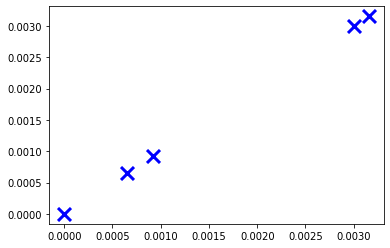

In [18]:
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="b",
    zorder=10,
);

ValueError: x and y must be the same size

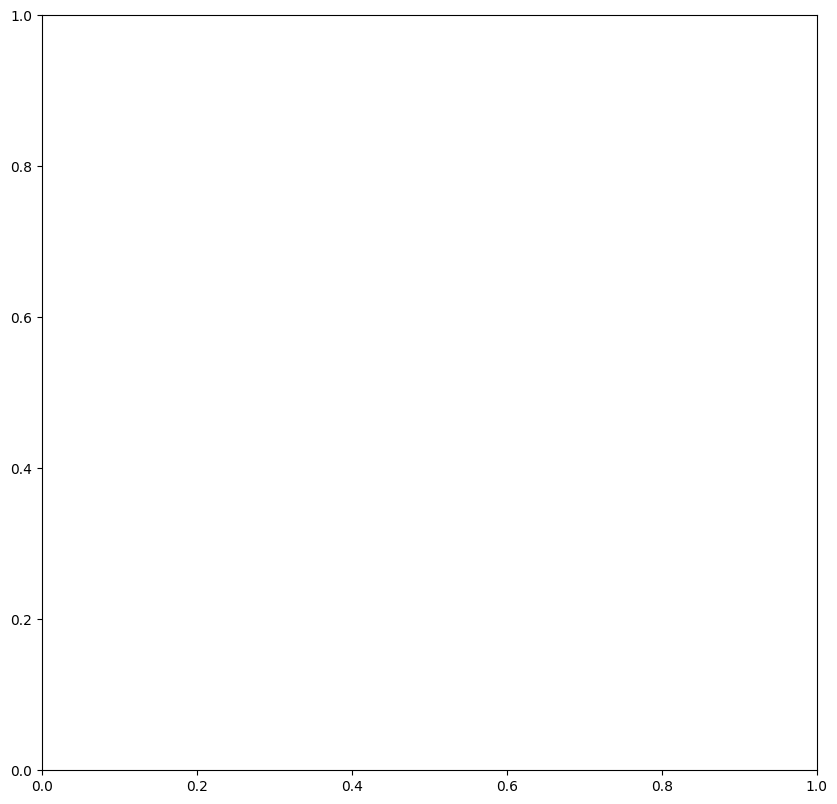

In [20]:
plt.figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')

# plt.xlabel(col_x)
# plt.ylabel(col_y)

plt.scatter(X, y, alpha = 0.25, s = 100, color='red')
plt.title("Kmeans Scatterplot of World Happiness vs GDP", fontsize=18)
plt.scatter(centroids[:,0], centroids[:,1], s = 100000, alpha=0.30)